In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from pandas.api.types import CategoricalDtype
import seaborn as sns

%load_ext tensorboard
import datetime

from tensorflow.keras.utils import to_categorical

filename = "../../Datasets/Sonar/sonar.all-data.csv"

df = pd.read_csv(filename,encoding = 'utf-8', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [2]:
#df.columns.tolist()
df.rename(columns = {60:'class_val'},inplace = True)
df.head(1)
df['class_val'].value_counts()

M    111
R     97
Name: class_val, dtype: int64

In [3]:
# Create category types.
#class_type = CategoricalDtype(['Type1','Type2','Type3'], ordered=True)

# Convert all categorical values to category type.
#df.class_val = df.class_val.astype(class_type)

In [4]:
# Convert categories into integers for each column.
df.class_val=df.class_val.replace({'M':1, 'R':0})

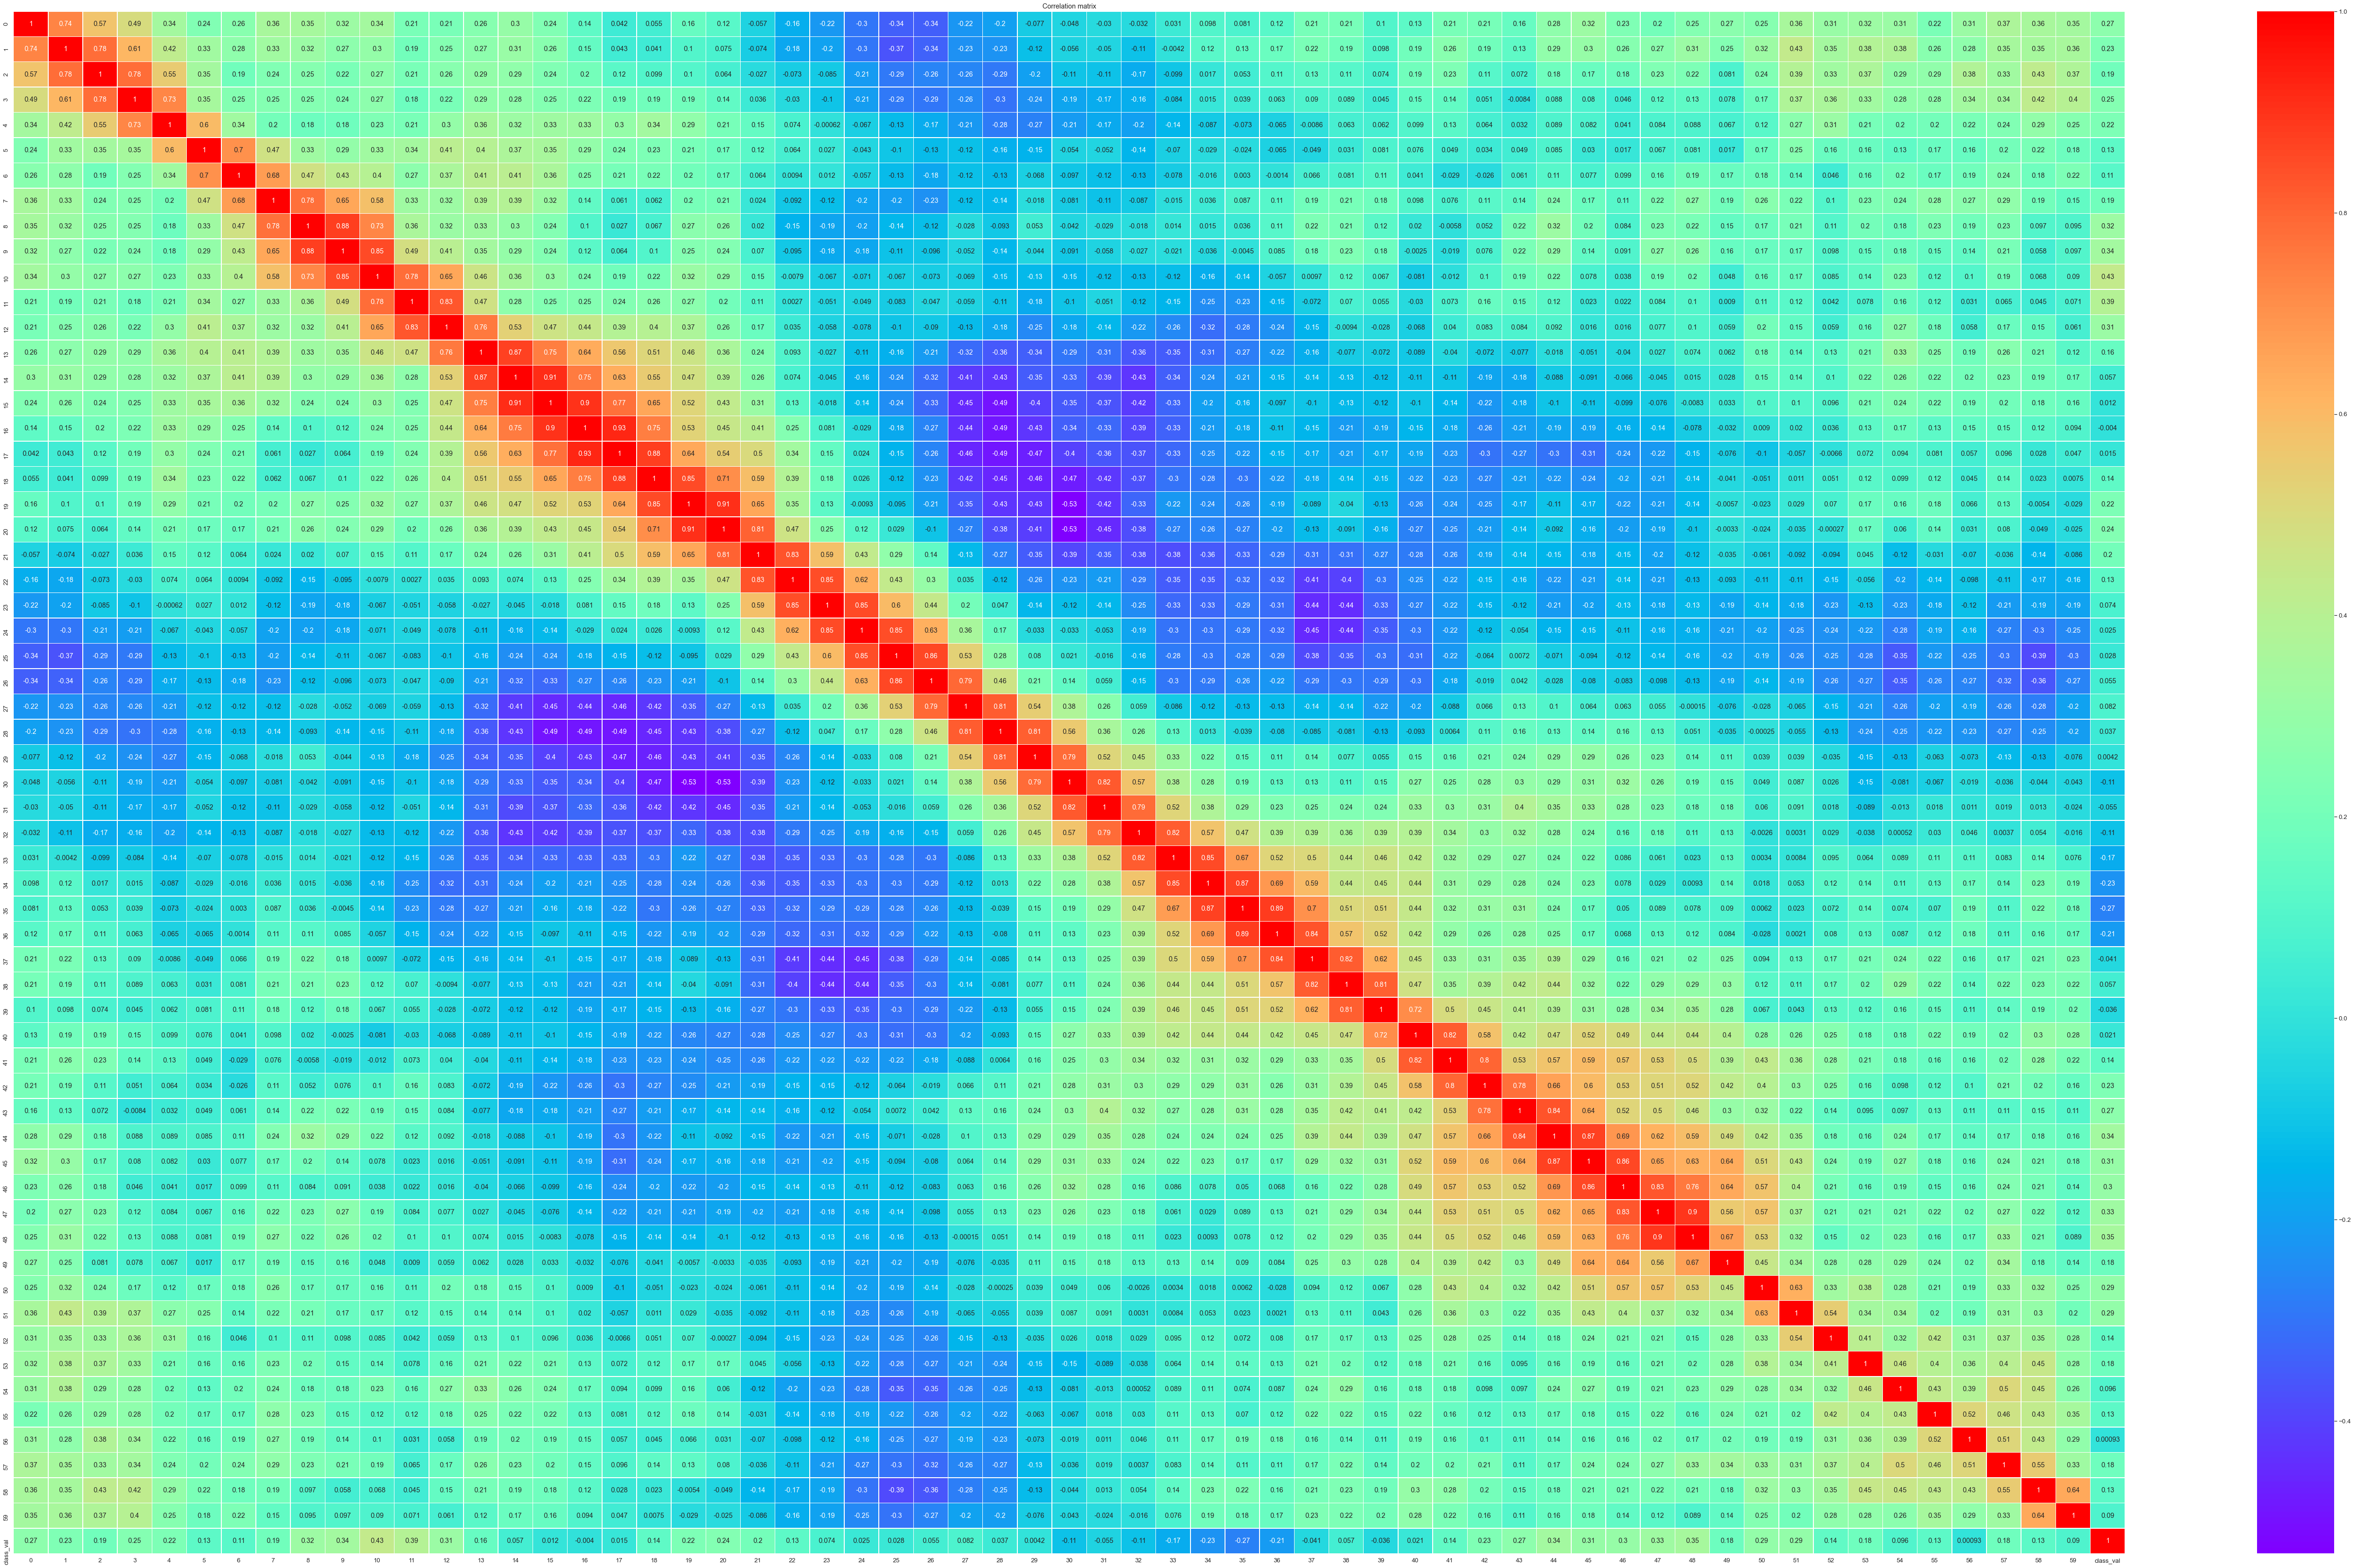

In [5]:

plt.figure(figsize=(100,60))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(),annot=True, cmap='rainbow',linewidth=0.5)
plt.title('Correlation matrix');


In [6]:
# Choose attribute columns and class column.
X=df[df.columns[0:-1]]
y=df['class_val']

y = np.array(y)
y = to_categorical(y)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,class_val
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


In [7]:
initializer0 = keras.initializers.RandomUniform(minval = -2, maxval =2)
initializer1 = keras.initializers.RandomUniform(minval = -2, maxval =2)
initializer2 = keras.initializers.RandomUniform(minval = -2, maxval =2)

class Diffact(keras.layers.Layer):
    def __init__(self):
        super(Diffact, self).__init__()
        self.k0 = self.add_weight(name='k0', shape = (), initializer=initializer0, trainable=True)
        self.k1 = self.add_weight(name='k1', shape = (), initializer=initializer1, trainable=True)
        self.k2 = self.add_weight(name='k2', shape = (), initializer=initializer2, trainable=True)
        
    def call(self, inputs):
        return self.k0 + tf.multiply(inputs, self.k1) + tf.multiply(tf.multiply(inputs,inputs), self.k2)

from keras import backend as K

class Mish(keras.layers.Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

Using TensorFlow backend.


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
# split data into train, test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42, shuffle=True)
#kipping y since value already 1 or 0
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
'''
# normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
'''
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (df.columns)

(187, 60) (187, 2)
(21, 60) (21, 2)
Index([          0,           1,           2,           3,           4,
                 5,           6,           7,           8,           9,
                10,          11,          12,          13,          14,
                15,          16,          17,          18,          19,
                20,          21,          22,          23,          24,
                25,          26,          27,          28,          29,
                30,          31,          32,          33,          34,
                35,          36,          37,          38,          39,
                40,          41,          42,          43,          44,
                45,          46,          47,          48,          49,
                50,          51,          52,          53,          54,
                55,          56,          57,          58,          59,
       'class_val'],
      dtype='object')


In [9]:
# create model with fully connected layers with dropout regulation
model = Sequential()
model.add(layers.Dense(35, input_dim=60))
diffact=Diffact()
model.add(diffact)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(25))
model.add(diffact)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                2135      
_________________________________________________________________
diffact (Diffact)            multiple                  3         
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                900       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 52        
Total params: 3,090
Trainable params: 3,090
Non-trainable params: 0
______________________________________________________

In [10]:
batch_size = 5
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

log_dir = "logs/fit41/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1 ,callbacks=[tensorboard_callback], verbose=1)


Epoch 1/100
 1/34 [..............................] - ETA: 0s - loss: 7.4536 - accuracy: 0.4000WARNING:tensorflow:From C:\Users\shamb\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 1s 15ms/step - loss: 2.6813 - accuracy: 0.5238 - val_loss: 0.7323 - val_accuracy: 0.6316
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 1.6063 - accuracy: 0.5298 - val_loss: 0.8536 - val_accuracy: 0.3158
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 1.3544 - accuracy: 0.5357 - val_loss: 0.6295 - val_accuracy: 0.6842
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 1.3130 - accuracy: 0.5119 - val_loss: 0.6308 - val_accuracy: 0.6316
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss

Epoch 55/100
34/34 [==============================] - 0s 2ms/step - loss: 0.4553 - accuracy: 0.7560 - val_loss: 0.5698 - val_accuracy: 0.6842
Epoch 56/100
34/34 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.8214 - val_loss: 0.5604 - val_accuracy: 0.6842
Epoch 57/100
34/34 [==============================] - 0s 2ms/step - loss: 0.4462 - accuracy: 0.7976 - val_loss: 0.6044 - val_accuracy: 0.6842
Epoch 58/100
34/34 [==============================] - 0s 2ms/step - loss: 0.4095 - accuracy: 0.7976 - val_loss: 0.5977 - val_accuracy: 0.6842
Epoch 59/100
34/34 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.7798 - val_loss: 0.5656 - val_accuracy: 0.7368
Epoch 60/100
34/34 [==============================] - 0s 2ms/step - loss: 0.3871 - accuracy: 0.8036 - val_loss: 0.5487 - val_accuracy: 0.6842
Epoch 61/100
34/34 [==============================] - 0s 2ms/step - loss: 0.3738 - accuracy: 0.8274 - val_loss: 0.6482 - val_accuracy: 0.6316
Epoch 

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2678823173046112
Test accuracy: 0.9047619104385376


In [12]:
print("AF coefficients (weights) {}".format(diffact.get_weights()))

AF coefficients (weights) [0.68349075, 1.3685337, 0.65780455]


In [13]:
%tensorboard --logdir logs/fit41 --port=6049

Reusing TensorBoard on port 6049 (pid 20684), started 0:07:22 ago. (Use '!kill 20684' to kill it.)

In [14]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,class_val
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507,0.533654
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031,0.500070
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600,0.000000
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100,0.000000
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300,1.000000
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525,1.000000
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900,1.000000
